In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import brier_score_loss

from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition

import plotly.graph_objects as go
from sklearn.calibration import calibration_curve


import csv as csv
import pathlib
import warnings
#used for plots
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d

import os, json
import re

from mplsoccer import Pitch, VerticalPitch
from adjustText import adjust_text
from highlight_text import ax_text
from highlight_text import fig_text
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


import eli5
from eli5.sklearn import PermutationImportance
import tensorflow as tf
#tf.compat.v1.disable_v2_behavior()
import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

#Importing other libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

#Importing libraries for model evaluation 
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')



2024-06-19 08:35:39.476464: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def read_match_data(DATADIR,gameid):
    '''
    read_match_data(DATADIR,gameid):
    read all Metrica match data (tracking data for home & away teams, and ecvent data)
    '''
    tracking_home = tracking_data(DATADIR,gameid,'Home')
    tracking_away = tracking_data(DATADIR,gameid,'Away')
    events = read_event_data(DATADIR,gameid)
    return tracking_home,tracking_away,events

def read_event_data(DATADIR,game_id):
    '''
    read_event_data(DATADIR,game_id):
    read Metrica event data  for game_id and return as a DataFrame
    '''
    eventfile = '/Sample_Game_%d/Sample_Game_%d_RawEventsData.csv' % (game_id,game_id) # filename
    events = pd.read_csv('{}/{}'.format(DATADIR, eventfile)) # read data
    return events

def tracking_data(DATADIR,game_id,teamname):
    '''
    tracking_data(DATADIR,game_id,teamname):
    read Metrica tracking data for game_id and return as a DataFrame. 
    teamname is the name of the team in the filename. For the sample data this is either 'Home' or 'Away'.
    '''
    teamfile = '/Sample_Game_%d/Sample_Game_%d_RawTrackingData_%s_Team.csv' % (game_id,game_id,teamname)
    # First:  deal with file headers so that we can get the player names correct
    csvfile =  open('{}/{}'.format(DATADIR, teamfile), 'r') # create a csv file reader
    reader = csv.reader(csvfile) 
    teamnamefull = next(reader)[3].lower()
    print("Reading team: %s" % teamnamefull)
    # construct column names
    jerseys = [x for x in next(reader) if x != ''] # extract player jersey numbers from second row
    columns = next(reader)
    for i, j in enumerate(jerseys): # create x & y position column headers for each player
        columns[i*2+3] = "{}_{}_x".format(teamname, j)
        columns[i*2+4] = "{}_{}_y".format(teamname, j)
    columns[-2] = "ball_x" # column headers for the x & y positions of the ball
    columns[-1] = "ball_y"
    # Second: read in tracking data and place into pandas Dataframe
    tracking = pd.read_csv('{}/{}'.format(DATADIR, teamfile), names=columns, index_col='Frame', skiprows=3)
    return tracking


In [3]:
DATADIR = '/Users/aritramajumdar/Desktop/The_last_one/sample-data-master/data/'
game_id = 2 # let's look at sample match 2

In [4]:
def process_event_data(events):
    """
    Processes event data by adding previous event type and subtype, and scaling coordinates.

    Parameters:
    events (DataFrame): The input DataFrame containing event data.

    Returns:
    DataFrame: The processed DataFrame with additional columns.
    """
    # Shift the 'Type' and 'Subtype' columns by 1 to get the previous event type and subtype
    events["PreviousType"] = events["Type"].shift(1, fill_value=0)
    events["PreviousSubtype"] = events["Subtype"].shift(1, fill_value=0)

    # Scale 'Start X' and 'Start Y' coordinates to 100
    events['X_start'] = events['Start X'] * 100.0
    events['Y_start'] = events['Start Y'] * 100.0

    # Rename the 'Start Time [s]' column to 'Time [s]'
    events.rename(columns={'Start Time [s]': 'Time [s]'}, inplace=True)
    
    return events


def process_tracking_data(tracking_home, tracking_away):
    """
    Processes tracking data by merging home and away team data and removing ball coordinates.

    Parameters:
    tracking_home (DataFrame): The input DataFrame containing tracking data for the home team.
    tracking_away (DataFrame): The input DataFrame containing tracking data for the away team.

    Returns:
    DataFrame: The merged DataFrame containing tracking data for both teams.
    """
    # Drop ball coordinates from home team tracking data
    tracking_home.drop(columns=['ball_x', 'ball_y'], axis=1, inplace=True)
    
    # Merge home and away team tracking data on 'Period', 'Time [s]', and 'Frame' columns
    tracking = pd.merge(tracking_home, tracking_away, on=['Period', 'Time [s]', 'Frame'])

    return tracking



def to_metric_coordinates(data, field_dimen=(100.0, 100.0)):
    """
    Converts position data from Metrica units to metric units based on field dimensions.

    Parameters:
    data (DataFrame): The input DataFrame containing position data.
    field_dimen (tuple): The dimensions of the field in meters (width, height).

    Returns:
    DataFrame: The DataFrame with converted position data in metric units.
    """
    # Identify columns containing x and y coordinates
    x_columns = [c for c in data.columns if c[-1].lower() == 'x']
    y_columns = [c for c in data.columns if c[-1].lower() == 'y']
    
    # Scale x and y coordinates by the field dimensions
    data[x_columns] = data[x_columns] * field_dimen[0]
    data[y_columns] = data[y_columns] * field_dimen[1]
    
    return data


In [5]:
# Read and process event data
events = read_event_data(DATADIR, game_id)  # Read event data using a custom function
events = process_event_data(events)  # Process event data to add previous event type and subtype, scale coordinates

# Read tracking data for home and away teams
tracking_home = tracking_data(DATADIR, game_id, 'Home')  # Read tracking data for the home team
tracking_away = tracking_data(DATADIR, game_id, 'Away')  # Read tracking data for the away team

# Process and combine tracking data
tracking = process_tracking_data(tracking_home, tracking_away)  # Merge home and away tracking data
tracking = to_metric_coordinates(tracking)  # Convert tracking data to metric coordinates
tracking = tracking.fillna(110.0)  # Fill missing values with a specific value (e.g., 110.0)

# Merge event data with tracking data
data = pd.merge(events, tracking, on=['Period', 'Time [s]'])  # Merge on 'Period' and 'Time [s]' columns
data.shape

Reading team: home
Reading team: away


(1935, 72)

In [6]:
import pandas as pd

def process_merged_data(data):
    """
    Processes merged event and tracking data, flipping coordinates for certain periods.

    Parameters:
    data (DataFrame): The merged DataFrame containing event and tracking data.

    Returns:
    DataFrame: The processed DataFrame with flipped coordinates for specific periods and teams.
    """
    # Separate home and away team events
    home_events = data.loc[data['Team'] == 'Home']
    away_events = data.loc[data['Team'] == 'Away']
    
    # Separate events by period for home team
    period_1_home = home_events.loc[home_events['Period'] == 1]
    period_2_home = home_events.loc[home_events['Period'] == 2]

    # Separate events by period for away team
    period_1_away = away_events.loc[away_events['Period'] == 1]
    period_2_away = away_events.loc[away_events['Period'] == 2]
    
    # Flip X coordinates for home team in the first period
    period_1_home['X_start'] = 100.0 - period_1_home['X_start']
    x_cols = [col for col in period_1_home.columns if col.endswith('_x')]
    period_1_home[x_cols] = 100.0 - period_1_home[x_cols]

    # Flip X coordinates for away team in the second period
    period_2_away['X_start'] = 100.0 - period_2_away['X_start']
    x_cols = [col for col in period_2_away.columns if col.endswith('_x')]
    period_2_away[x_cols] = 100.0 - period_2_away[x_cols]

    # Flip Y coordinates for home team in the second period
    period_2_home['Y_start'] = 100.0 - period_2_home['Y_start']
    y_cols = [col for col in period_2_home.columns if col.endswith('_y')]
    period_2_home[y_cols] = 100.0 - period_2_home[y_cols]

    # Flip Y coordinates for away team in the first period
    period_1_away['Y_start'] = 100.0 - period_1_away['Y_start']
    y_cols = [col for col in period_1_away.columns if col.endswith('_y')]
    period_1_away[y_cols] = 100.0 - period_1_away[y_cols]

    # Concatenate all processed periods and sort by time
    data_df = pd.concat([period_1_home, period_2_home, period_1_away, period_2_away])
    data_df = data_df.sort_values(by='Time [s]', ascending=True)
    
    return data_df



def count_shots_goals(data_df):
    """
    Counts and prints the number of events, shots, and goals for home and away teams.

    Parameters:
    data_df (DataFrame): The processed DataFrame containing event and tracking data.

    Returns:
    tuple: Contains DataFrames for home events, away events, all shots, home shots, away shots, home goals, and away goals.
    """
    # Separate home and away team events
    home_events = data_df[data_df['Team'] == 'Home']
    away_events = data_df[data_df['Team'] == 'Away']

    print("Home events:", home_events.shape)
    print("Away events:", away_events.shape)

    # Get all shots
    shots = data_df[data_df['Type'] == 'SHOT']
    home_shots = home_events[home_events['Type'] == 'SHOT']
    away_shots = away_events[away_events['Type'] == 'SHOT']

    print("All shots:", shots.shape[0])
    print("Home shots:", home_shots.shape[0])
    print("Away shots:", away_shots.shape[0])

    # Get the shots that led to a goal
    home_goals = home_shots[home_shots['Subtype'].str.contains('-GOAL', na=False)].copy()
    away_goals = away_shots[away_shots['Subtype'].str.contains('-GOAL', na=False)].copy()

    print("Home goals:", home_goals.shape[0])
    print("Away goals:", away_goals.shape[0])
    
    home_shots_open = home_shots[home_shots['PreviousType'] != 'SET PIECE']
    home_shots_set = home_shots[home_shots['PreviousType'] == 'SET PIECE']
    
    print("Home shots Open play:", home_shots_open.shape[0])
    print("Home shots Set Piece:", home_shots_set.shape[0])
    
    away_shots_open = away_shots[away_shots['PreviousType'] != 'SET PIECE']
    away_shots_set = away_shots[away_shots['PreviousType'] == 'SET PIECE']
    
    print("Away shots Open play:", away_shots_open.shape[0])
    print("Away shots Set Piece:", away_shots_set.shape[0])
    
    
    home_goals_open = home_goals[home_goals['PreviousType'] != 'SET PIECE']
    home_goals_set = home_goals[home_goals['PreviousType'] == 'SET PIECE']
    
    print("Home Goals Open play:", home_goals_open.shape[0])
    print("Home Goals Set Piece:", home_goals_set.shape[0])
    
    away_goals_open = away_goals[away_goals['PreviousType'] != 'SET PIECE']
    away_goals_set = away_goals[away_goals['PreviousType'] == 'SET PIECE']
    
    print("Away Goals Open play:", away_goals_open.shape[0])
    print("Away Goals Set Piece:", away_goals_set.shape[0])
    
    return home_events, away_events, shots, home_shots, away_shots, home_goals, away_goals

    

In [7]:
# Process the merged data
data_df = process_merged_data(data)

# Count shots and goals
home_events, away_events, shots, home_shots, away_shots, home_goals, away_goals = count_shots_goals(data_df)

Home events: (1044, 72)
Away events: (891, 72)
All shots: 24
Home shots: 13
Away shots: 11
Home goals: 3
Away goals: 2
Home shots Open play: 12
Home shots Set Piece: 1
Away shots Open play: 9
Away shots Set Piece: 2
Home Goals Open play: 3
Home Goals Set Piece: 0
Away Goals Open play: 1
Away Goals Set Piece: 1


In [8]:
def process(df):
    """
    Processes the DataFrame by converting coordinate pairs to location lists and adding new columns.

    Parameters:
    df (DataFrame): The input DataFrame.

    Returns:
    DataFrame: The processed DataFrame with new columns for locations and body parts.
    """
    # Identify columns ending with '_x' and '_y'
    x_columns = [col for col in df.columns if col.endswith('_x')]
    y_columns = [col for col in df.columns if col.endswith('_y')]

    # Ensure that there are matching pairs of _x and _y columns
    assert len(x_columns) == len(y_columns), "Mismatch in number of _x and _y columns"

    # Create new columns with lists of corresponding _x and _y values
    for x_col, y_col in zip(x_columns, y_columns):
        new_col_name = x_col.replace('_x', '_location')
        df[new_col_name] = df[[x_col, y_col]].values.tolist()

    # Create a 'location' column combining 'X_start' and 'Y_start'
    df['location'] = df[['X_start', 'Y_start']].values.tolist()

    # Create a 'BodyPart' column based on the 'Subtype' column
    df['BodyPart'] = df['Subtype'].apply(lambda x: 'Head' if x.startswith('HEAD') else 'Other')
    
    df['isGoal'] = df['Subtype'].apply(lambda x: 'Goal' if x.endswith('GOAL') else 'Other')
    
    df['Minute'] = df['Time [s]']/60.0

    return df


def is_point_in_triangle(pt, v1, v2, v3):
    """
    Checks if a point is inside or on the edge of a triangle using barycentric coordinates.

    Parameters:
    pt (tuple): The point to check.
    v1, v2, v3 (tuple): The vertices of the triangle.

    Returns:
    bool: True if the point is inside or on the edge of the triangle, False otherwise.
    """
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

    d1 = sign(pt, v1, v2)
    d2 = sign(pt, v2, v3)
    d3 = sign(pt, v3, v1)

    return (d1 == 0 or d2 == 0 or d3 == 0) or ((d1 < 0) == (d2 < 0) == (d3 < 0))



def count_players_in_triangle(row):
    """
    Counts the number of home and away players within the triangle defined by the shooting location and the goal posts.

    Parameters:
    row (Series): A row of the DataFrame representing an event.

    Returns:
    tuple: A tuple containing the counts of home and away players in the triangle.
    """
    # Define the vertices of the triangle
    shooting_location = row['location']
    v1 = shooting_location
    v2 = (100, 46)
    v3 = (100, 54)

    home_count = 0
    away_count = 0

    # Iterate through the columns of the DataFrame
    for col in row.index:
        if col.startswith('Home') and col.endswith('_location'):
            player_location = row[col]
            if is_point_in_triangle(player_location, v1, v2, v3):
                home_count += 1
        elif col.startswith('Away') and col.endswith('_location'):
            player_location = row[col]
            if is_point_in_triangle(player_location, v1, v2, v3):
                away_count += 1

    return home_count, away_count


def calculate_interference_on_shooter(row, proximity_threshold=2):
    """
    Calculates the degree of interference exerted on the shot-taker from defenders.

    Parameters:
    row (Series): A row of the DataFrame representing an event.
    proximity_threshold (float): The distance threshold to consider interference.

    Returns:
    str: The degree of interference ('Low', 'Medium', 'High').
    """
    # Convert the shooting location coordinates to a NumPy array
    shooting_location = np.array(row['location'])
    
    # Initialize the count of defenders within the proximity threshold
    defender_count = 0

    # Iterate through each column in the row
    for col in row.index:
        # Check if the column corresponds to an away player's location (i.e., defender)
        if col.startswith('Away') and col.endswith('_location'):
            # Convert the defender's location coordinates to a NumPy array
            defender_location = np.array(row[col])
            # Calculate the Euclidean distance between the defender and the shooting location
            distance = np.linalg.norm(defender_location - shooting_location)
            # If the distance is within the proximity threshold, increment the defender count
            if distance <= proximity_threshold:
                defender_count += 1

    # Determine the degree of interference based on the number of defenders within the proximity threshold
    if defender_count == 0:
        return 'Low'  # No defenders are close to the shot-taker
    elif defender_count == 1:
        return 'Medium'  # One defender is close to the shot-taker
    else:
        return 'High'  # More than one defender is close to the shot-taker


def distance_calculation(df):
    """
    Calculates distances from the shot location to the goal posts and goal on the field and adds them as new columns.

    Parameters:
    df (DataFrame): The input DataFrame.

    Returns:
    DataFrame: The DataFrame with new distance columns.
    """
    # Calculate distances to points (100, 46), (100, 54), and (100, 50)
    df['shot_a'] = np.sqrt((df['x']-100)**2 + (df['y']-46)**2) #Distance to the goal post located at (100, 46)
    df['shot_b'] = np.sqrt((df['x']-100)**2 + (df['y']-54)**2) #Distance to the goal post located at (100, 54)
    df['shot_c'] = np.sqrt((df['x']-100)**2 + (df['y']-50)**2) #Distance to the goal 

    # Round distances to 2 decimal places
    df['shot_a'] = df['shot_a'].round(2)
    df['shot_b'] = df['shot_b'].round(2)
    df['shot_c'] = df['shot_c'].round(2)

    return df

def angle_calculation(df):
    """
    Calculates the shot angle using the cosine rule and adds it as a new column.

    Parameters:
    df (DataFrame): The input DataFrame.

    Returns:
    DataFrame: The DataFrame with the new shot angle column.
    """
    df['shot_angle'] = np.arccos((df['shot_a']**2 + df['shot_b']**2 - 64) / (2 * df['shot_a'] * df['shot_b']))
    df['shot_angle'] = np.degrees(df['shot_angle'])
    df['shot_angle'] = df['shot_angle'].round(2)
    
    return df

def assign_zone(row):
    """
    Assigns a zone to each shot based on its x and y coordinates.

    Parameters:
    row (Series): A row from the DataFrame.

    Returns:
    str: The zone assigned to the shot.
    """
    x, y = row['x'], row['y']
    
    # Define zones based on x and y coordinates
    if 94 < x <= 100 and 46 <= y <= 54:
        return "Zone 1"
    elif 94 < x <= 100 and 54 < y <= 63:
        return "Zone 2"
    elif 94 < x <= 100 and 37 <= y < 46:
        return "Zone 3"
    elif 94 < x <= 100 and 19 <= y < 37:
        return "Zone 4"
    elif 94 < x <= 100 and 63 < y <= 81:
        return "Zone 5"
    elif 88 < x <= 94 and 46 <= y <= 54:
        return "Zone 6"
    elif 88 < x <= 94 and 54 < y <= 63:
        return "Zone 7"
    elif 88 < x <= 94 and 37 <= y < 46:
        return "Zone 8"
    elif 88 < x <= 94 and 19 <= y < 37:
        return "Zone 9"
    elif 88 < x <= 94 and 63 < y <= 81:
        return "Zone 10"
    elif 83 < x <= 88 and 46 <= y <= 54:
        return "Zone 11"
    elif 83 < x <= 88 and 54 < y <= 63:
        return "Zone 12"
    elif 83 < x <= 88 and 37 <= y < 46:
        return "Zone 13"
    elif 83 < x <= 88 and 19 <= y < 37:
        return "Zone 14"
    elif 83 < x <= 88 and 63 < y <= 81:
        return "Zone 15"
    elif 75 < x <= 83 and 37 <= y <= 50:
        return "Zone 16"
    elif 75 < x <= 83 and 50 <= y <= 63:
        return "Zone 17"
    elif 67 <= x <= 75 and 37 <= y < 50:
        return "Zone 18"
    elif 67 <= x <= 75 and 50 <= y <= 63:
        return "Zone 19"
    elif 67 <= x <= 83 and 19 <= y < 37:
        return "Zone 20"
    elif 67 <= x <= 83 and 63 < y <= 81:
        return "Zone 21"
    else:
        return "Other"
    
def cat_to_num(df, fixed_bodypart_mapping, fixed_interference_mapping, fixed_zone_mapping):
    # Apply the fixed mappings to the categorical columns
    try:
        df['BodyPart'] = df['BodyPart'].map(fixed_bodypart_mapping)
    except:
        None
    try:
        df['Interference_on_Shooter'] = df['Interference_on_Shooter'].map(fixed_interference_mapping)
    except:
        None
    try:
        df['zone'] = df['zone'].map(fixed_zone_mapping)
    except:
        None
    
    return df

def rename_columns(df):
    """
    Renames specific columns in the DataFrame for consistency and clarity.

    Parameters:
    df (DataFrame): The input DataFrame.

    Returns:
    DataFrame: The DataFrame with renamed columns.
    """
    # Rename columns using the provided mapping
    df.rename(columns={
        'X_start': 'x', 
        'Y_start': 'y', 
        'home_players_in_triangle': 'Number_Intervening_Teammates',
        'away_players_in_triangle': 'Number_Intervening_Opponents'
    }, inplace=True)
    
    return df


In [9]:
df = process(shots)


df[['home_players_in_triangle', 'away_players_in_triangle']] = df.apply(
    lambda row: pd.Series(count_players_in_triangle(row)), axis=1
)

df['Interference_on_Shooter'] = df.apply(calculate_interference_on_shooter, axis=1)


df = rename_columns(df)

df = distance_calculation(df)
df = angle_calculation(df)
df['zone'] = df.apply(assign_zone, axis=1)


df

,Team,Type,Subtype,Period,Start Frame,Time [s],End Frame,End Time [s],From,To,...,isGoal,Minute,Number_Intervening_Teammates,Number_Intervening_Opponents,Interference_on_Shooter,shot_a,shot_b,shot_c,shot_angle,zone
83,Home,SHOT,OFF TARGET-OUT,1,4419,176.76,4443,177.72,Player5,NaN,...,Other,2.946000,0,2,Low,26.42,33.62,29.97,6.71,Zone 14
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,...,Goal,8.134667,0,1,Medium,10.30,5.10,7.07,49.59,Zone 2
252,Home,SHOT,ON TARGET-SAVED,1,16484,659.36,16499,659.96,Player10,NaN,...,Other,10.989333,0,2,Low,17.03,23.71,20.25,12.58,Zone 9
297,Away,SHOT,BLOCKED,1,18515,740.60,18520,740.80,Player22,NaN,...,Other,12.343333,1,1,Medium,27.59,22.83,25.00,14.72,Zone 21
431,Home,SHOT,HEAD-OFF TARGET-OUT,1,27345,1093.80,27360,1094.40,Player3,NaN,...,Other,18.230000,0,1,Medium,15.81,10.30,12.73,26.27,Zone 7
472,Home,SHOT,ON TARGET-SAVED,1,29754,1190.16,29777,1191.08,Player4,NaN,...,Other,19.836000,0,2,Low,31.24,25.61,28.28,11.53,Zone 21
823,Away,SHOT,ON TARGET-GOAL,1,53049,2121.96,53075,2123.00,Player24,NaN,...,Goal,35.366000,1,0,Medium,11.31,8.00,8.94,45.02,Zone 6
852,Home,SHOT,HEAD-OFF TARGET-OUT,1,56079,2243.16,56131,2245.24,Player5,NaN,...,Other,37.386000,0,2,Low,11.18,16.40,13.45,25.87,Zone 8
962,Away,SHOT,OFF TARGET-HEAD-OUT,1,63362,2534.48,63372,2534.88,Player23,NaN,...,Other,42.241333,1,0,Medium,8.60,7.62,7.07,58.73,Zone 6
980,Away,SHOT,ON TARGET-SAVED,1,64772,2590.88,64799,2591.96,Player20,NaN,...,Other,43.181333,3,1,Medium,23.02,24.70,23.54,18.88,Zone 16


In [10]:
def plot_shot(shots, label, label1):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')

    # Create pitch
    pitch = Pitch(pitch_type='opta', pad_bottom=0.5, half=False, goal_type='box', goal_alpha=0.8, positional=True)
    pitch.draw(ax=ax)
    
    
    # Plot starting positions of goals
    pitch.scatter(shots['x'], shots['y'], facecolors='red', s=80, 
                  edgecolors='#343434', linewidths=1, alpha=0.8, ax=ax)

    corner_points = [(0.0, 0.0), (100.0, 0.0), (0.0, 100.0), (100.0, 100.0),
                    (100.0, 46.0), (100.0, 54.0)]
    for (x, y) in corner_points:
        pitch.scatter(x, y, facecolors='red', s=80, edgecolors='#343434', linewidths=1, alpha=0.8, ax=ax)
        ax.annotate(f"({x}, {y})", (x, y), textcoords="offset points", xytext=(10,10), ha='center', color='black', fontsize=12)
    
    ax.set_title(label, fontsize=22)  

    plt.tight_layout()

    plt.savefig("/Users/aritramajumdar/Desktop/The_last_one/" + label1 + ".png", dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()



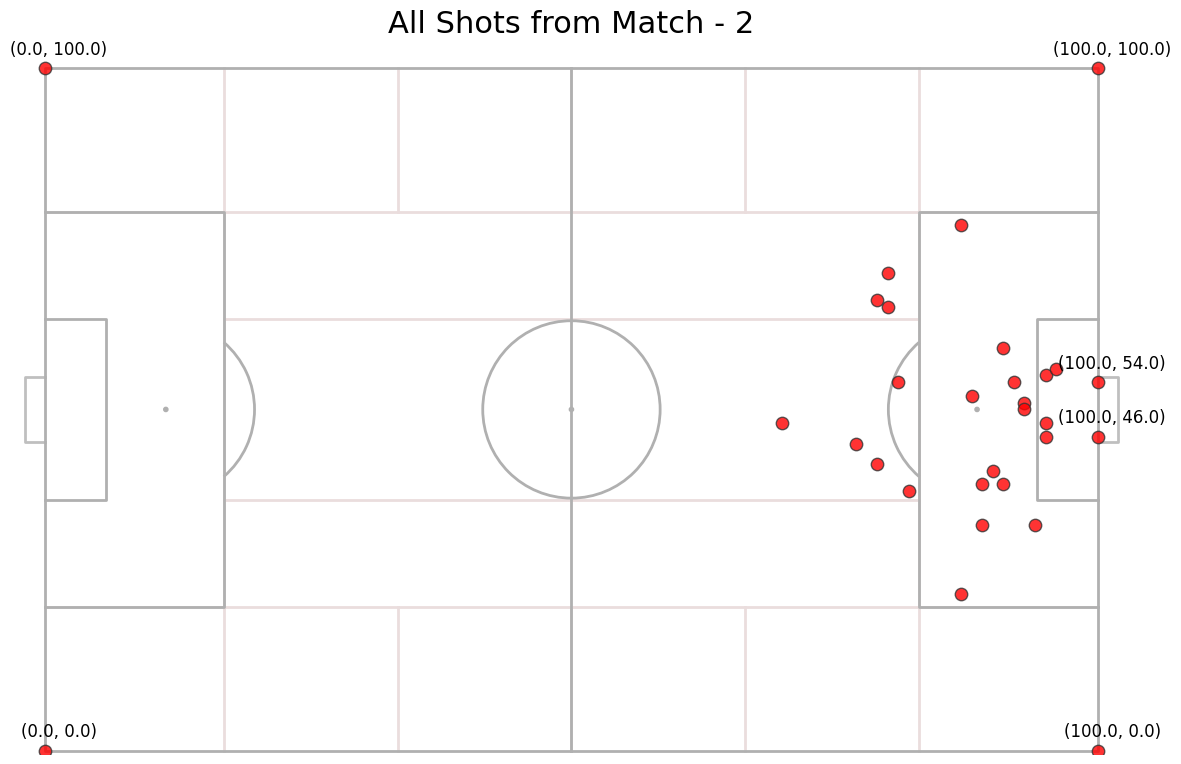

In [11]:
plot_shot(df, "All Shots from Match - 2", "Metrica shots")

In [12]:
home_shots = df[df['Team'] == 'Home']
away_shots = df[df['Team'] == 'Away']

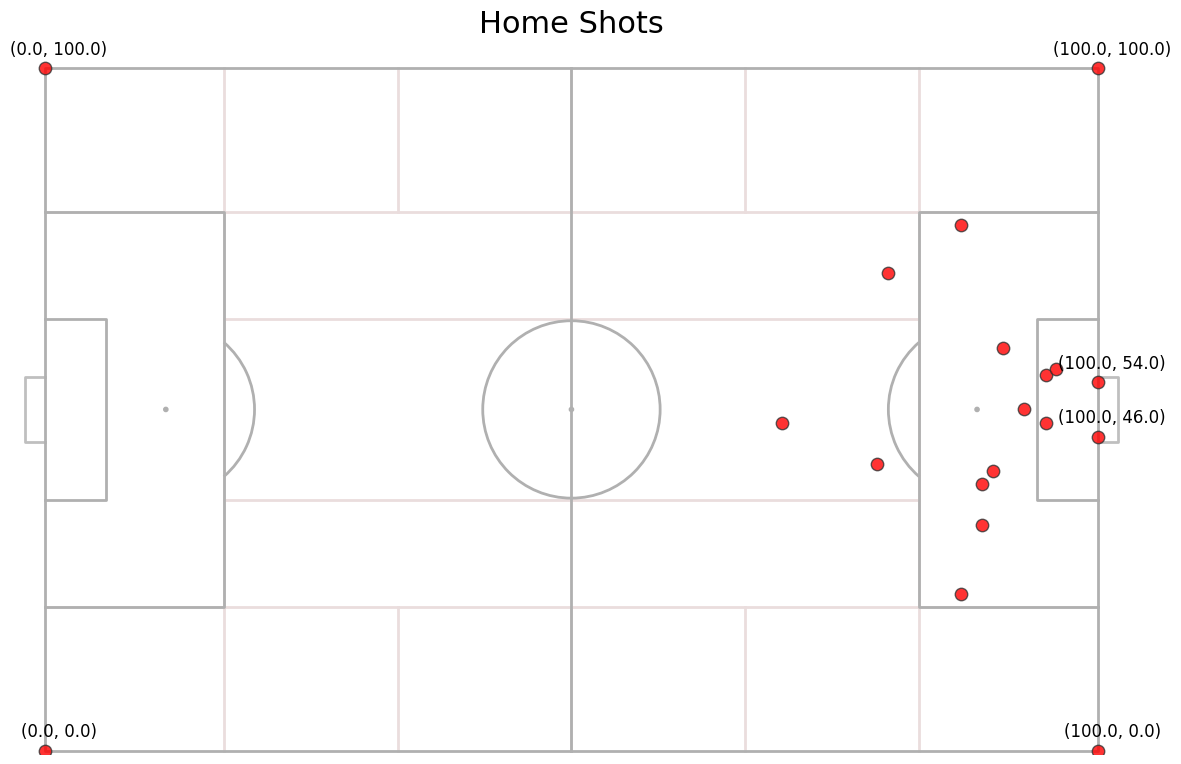

In [13]:
plot_shot(home_shots, "Home Shots", "Metrica Home shots")

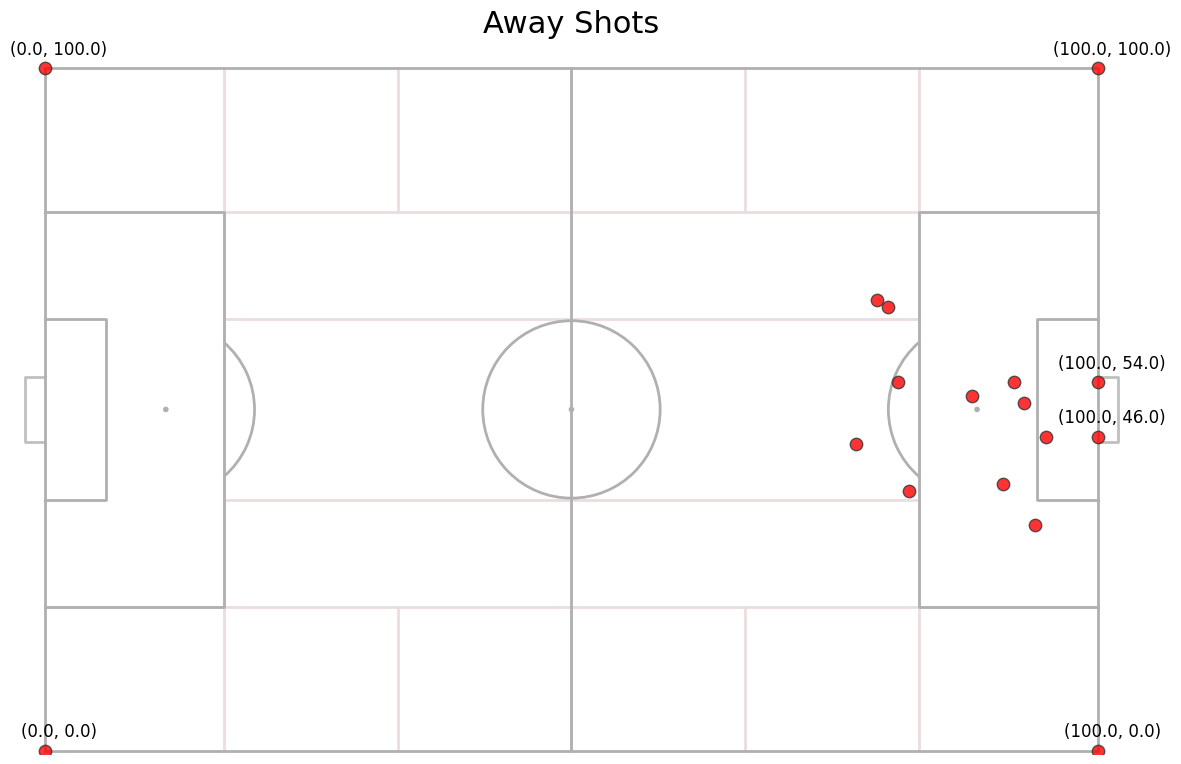

In [14]:
plot_shot(away_shots, "Away Shots", "Metrica Away shots")

In [15]:
def plot_shot_detail(goals, label, label1):
    # Extract Home and Away columns
    home_cols = [col for col in goals.columns if col.startswith('Home')]
    away_cols = [col for col in goals.columns if col.startswith('Away')]

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')

    # Create pitch
    #pitch = Pitch(pitch_type='opta', pad_bottom=0.5, half=True, goal_type='box', goal_alpha=0.8, positional=True)
    pitch = Pitch(pitch_type='opta', pad_bottom=0.5, half=False, goal_type='box', goal_alpha=0.8, positional=True)
    pitch.draw(ax=ax)

    # Plot starting positions of goals
    pitch.scatter(goals['x'], goals['y'], facecolors='red', s=80, 
                  edgecolors='#343434', linewidths=1, alpha=0.8, ax=ax)

    # Plot Home goals
    for i in range(1, 40):
        home_x = f'Home_{i}_x'
        home_y = f'Home_{i}_y'
        if home_x in goals.columns and home_y in goals.columns:
            pitch.scatter(goals[home_x], goals[home_y], facecolors='none', s=80, 
                          edgecolors='green', linewidths=1, alpha=0.8, ax=ax)

    # Plot Away goals
    for i in range(1, 40):
        away_x = f'Away_{i}_x'
        away_y = f'Away_{i}_y'
        if away_x in goals.columns and away_y in goals.columns:
            pitch.scatter(goals[away_x], goals[away_y], facecolors='none', s=80, 
                          edgecolors='blue', linewidths=1, alpha=0.8, ax=ax)
            
    # Adding a single point for the legend
    pitch.scatter([], [], facecolors='none', edgecolors='green', s=80, linewidths=1, alpha=0.8, label='Team mate', ax=ax)
    pitch.scatter([], [], facecolors='none', edgecolors='blue', s=80, linewidths=1, alpha=0.8, label='Opponent', ax=ax)

    # Add legend to the plot
    ax.legend()
    
    
    corner_points = [(0.0, 0.0), (100.0, 0.0), (0.0, 100.0), (100.0, 100.0),
                    (100.0, 46.0), (100.0, 54.0)]
    for (x, y) in corner_points:
        pitch.scatter(x, y, facecolors='orange', s=80, edgecolors='#343434', linewidths=1, alpha=0.8, ax=ax)
        ax.annotate(f"({x}, {y})", (x, y), textcoords="offset points", xytext=(0,10), ha='center', color='black', fontsize=12)
    
            
    pitch.lines(goals.x, goals.y,
                100.0, 46.0,
                  lw=2, transparent=True, comet=True,
                  color='#ad993c', ax=ax)
    
    pitch.lines(goals.x, goals.y,
                100.0, 54.0,
                  lw=2, transparent=True, comet=True,
                  color='#ad993c', ax=ax)
    
    
    title = f"{goals.Team.unique()[0]}'s " + label + f" Minute: {np.round((goals.Minute.unique()[0]), 2)}"
    
    ax.set_title(title, fontsize=22) 
    
    plt.savefig("/Users/aritramajumdar/Desktop/The_last_one/" + label1 + ".png", dpi=300, bbox_inches='tight')

    
    plt.show()


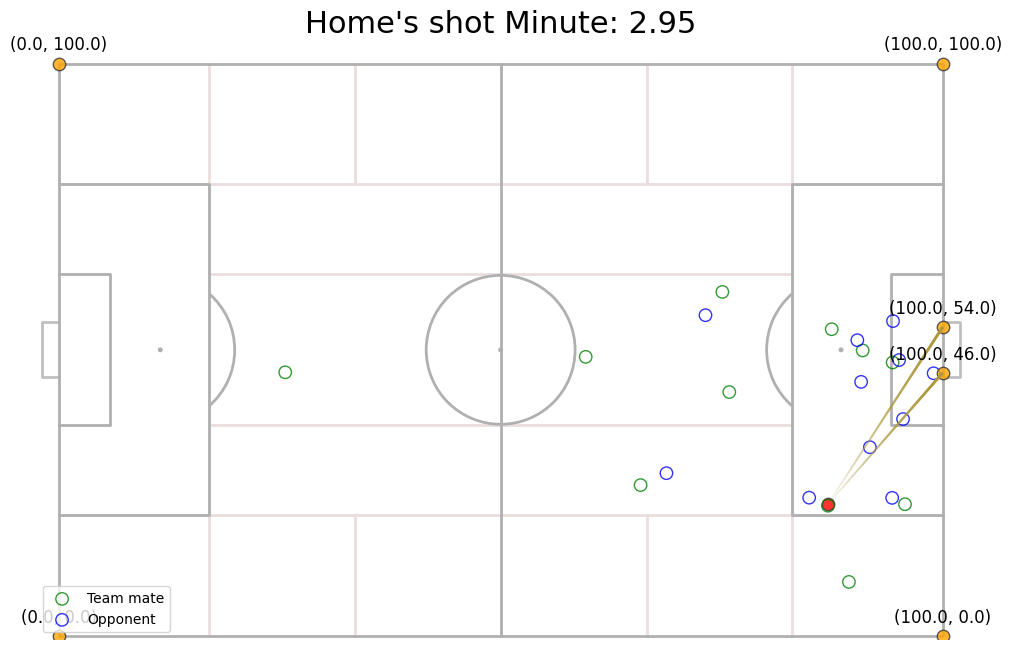

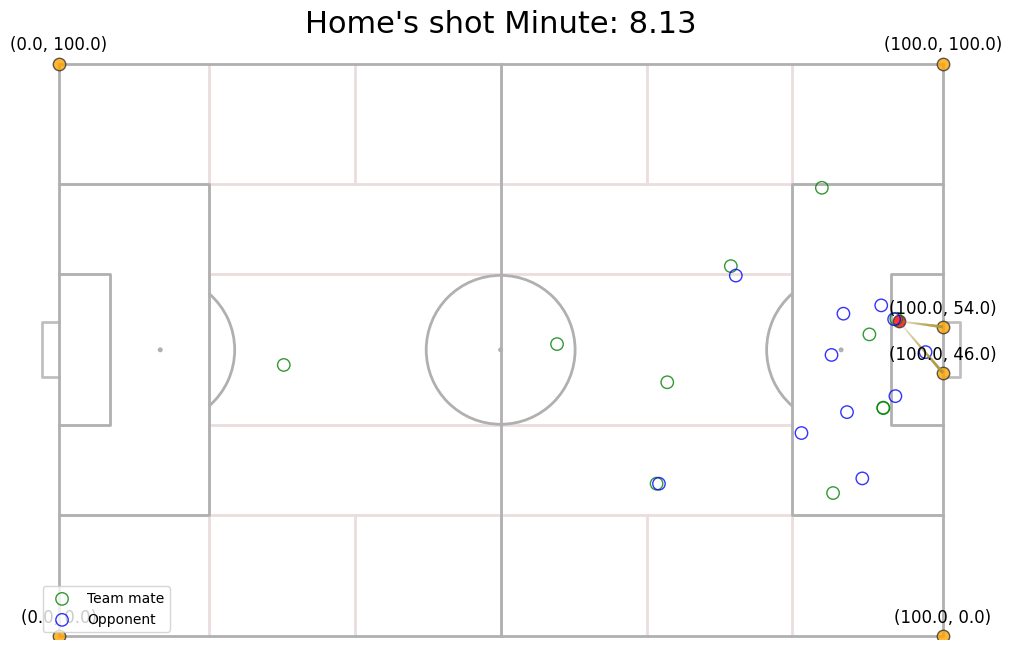

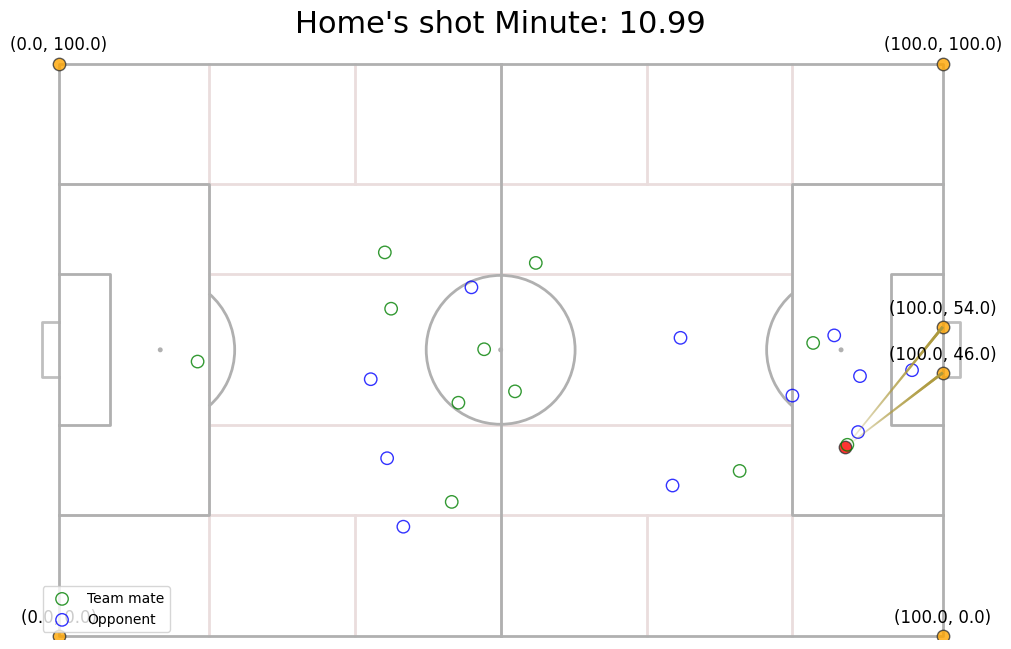

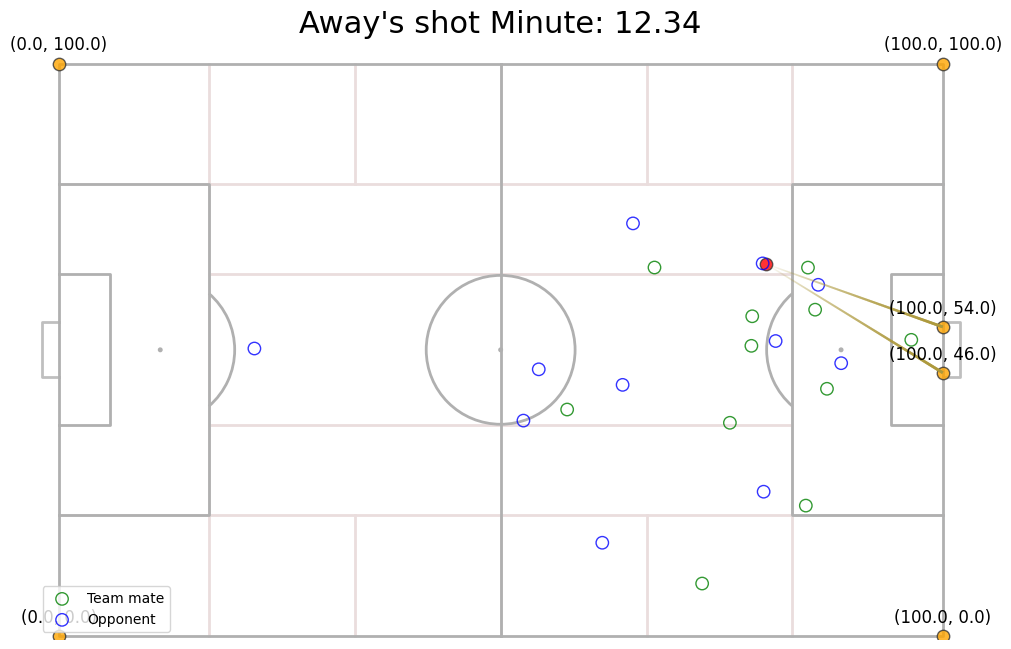

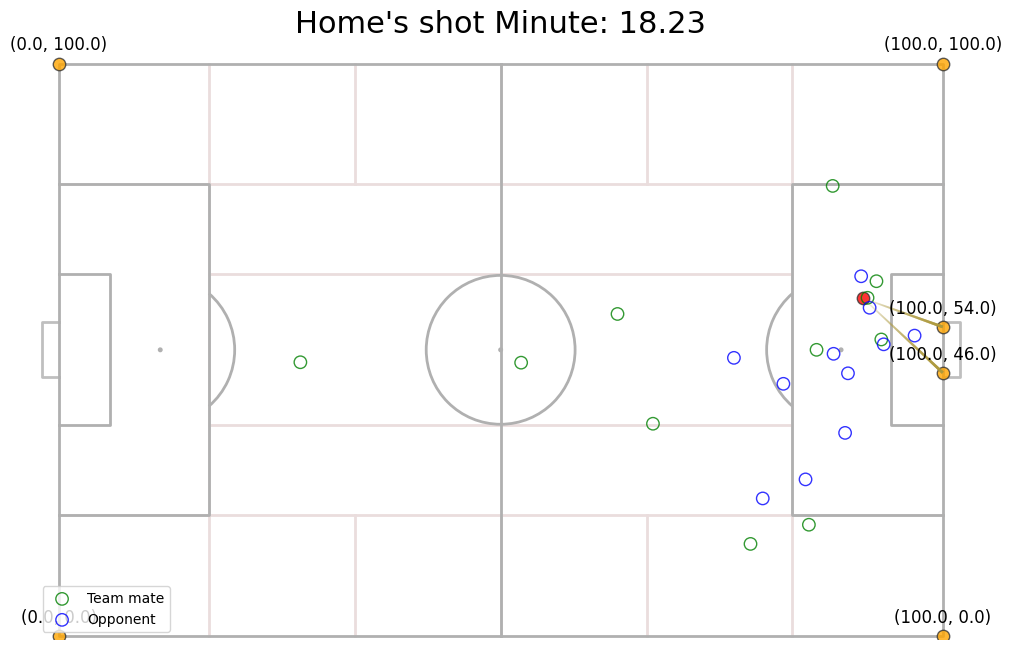

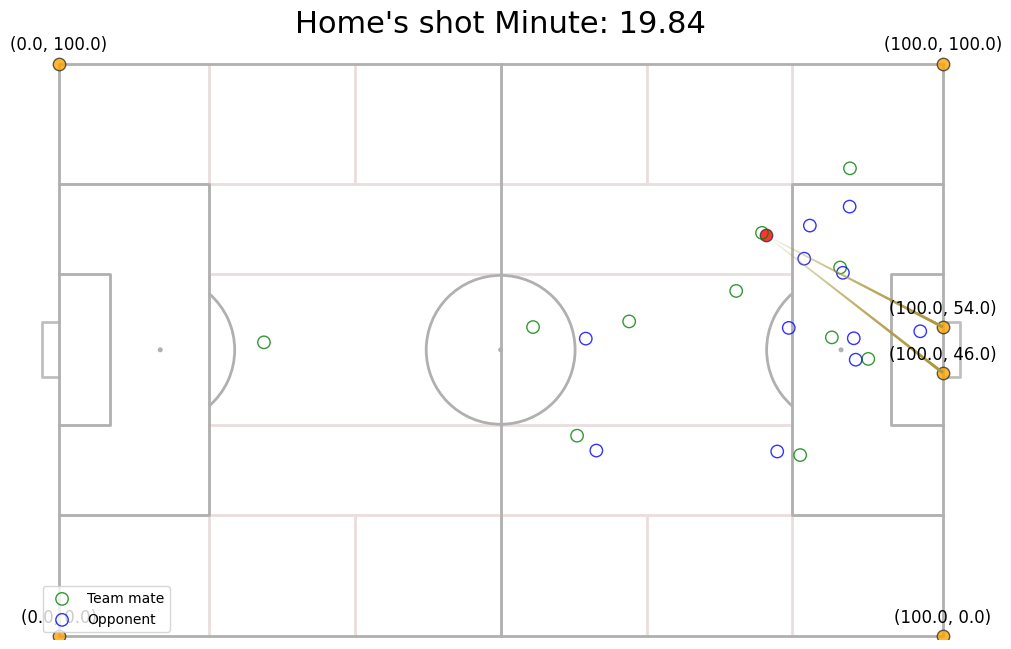

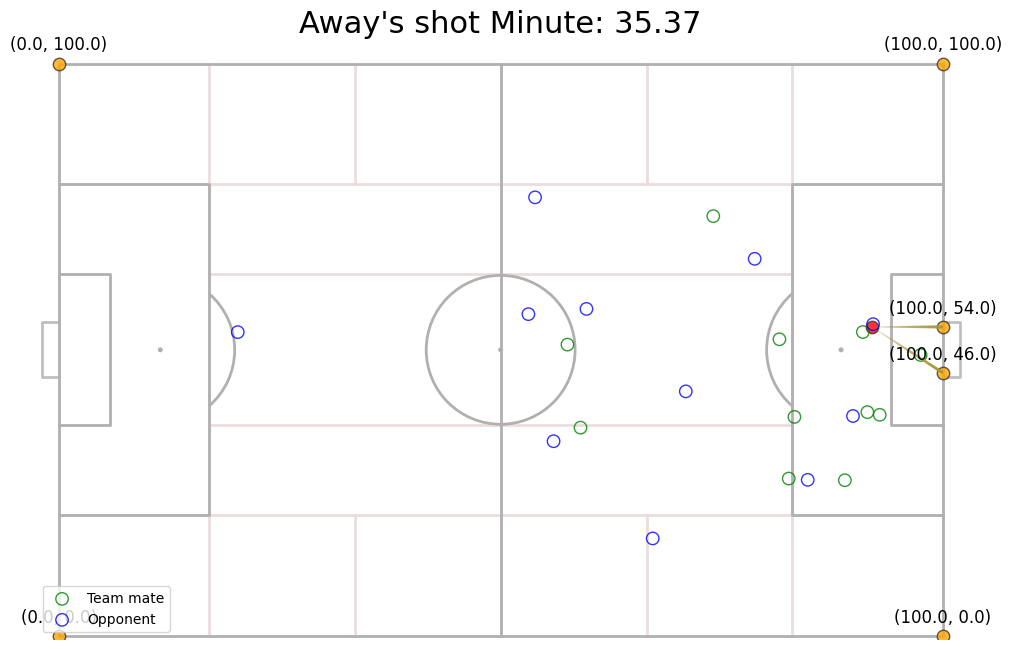

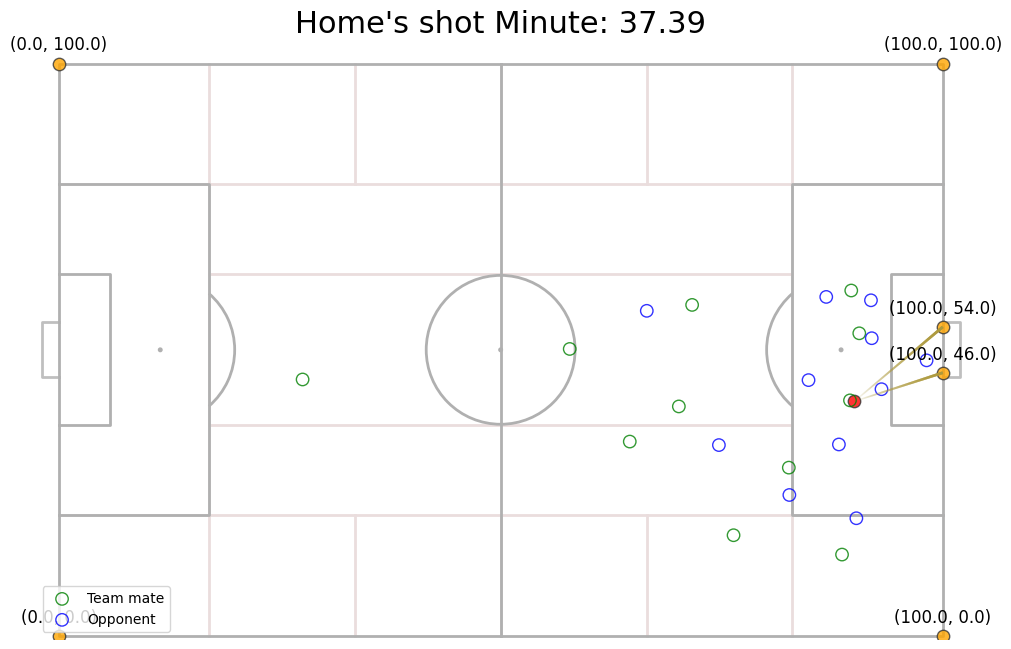

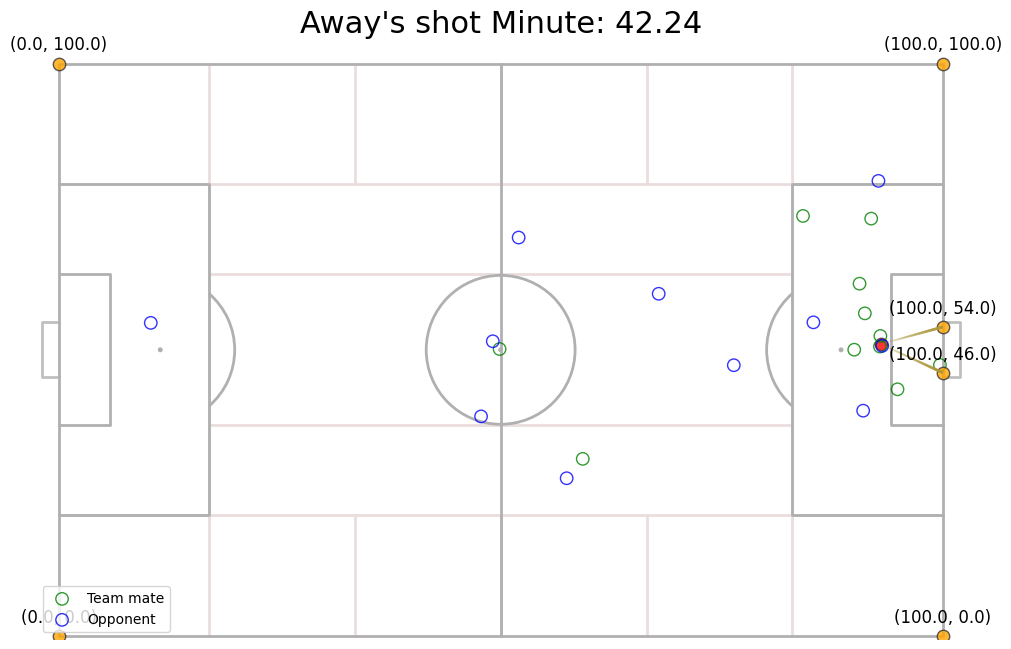

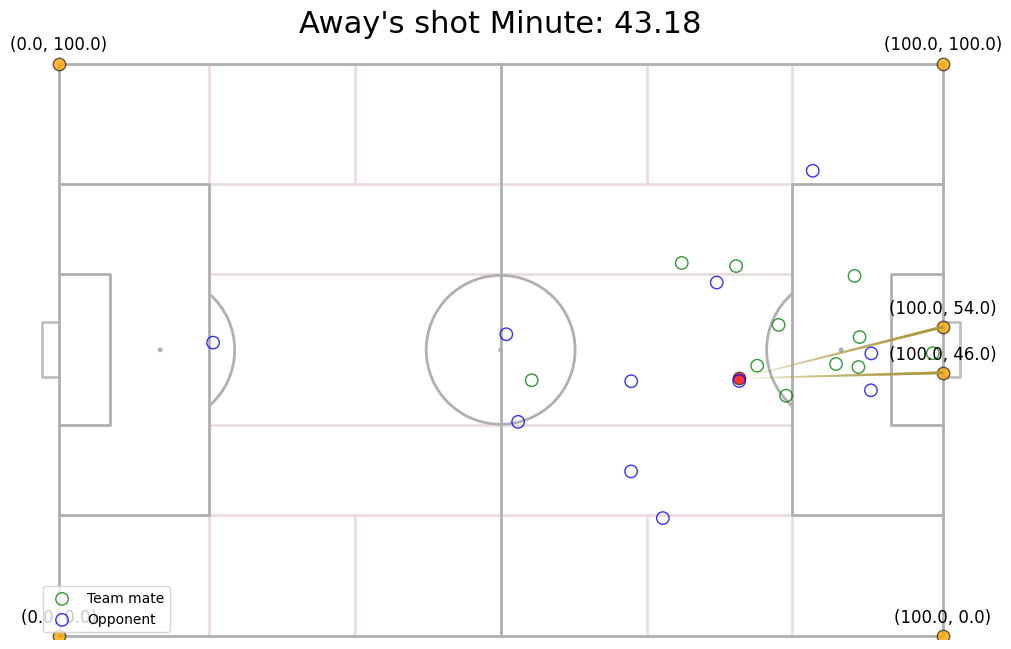

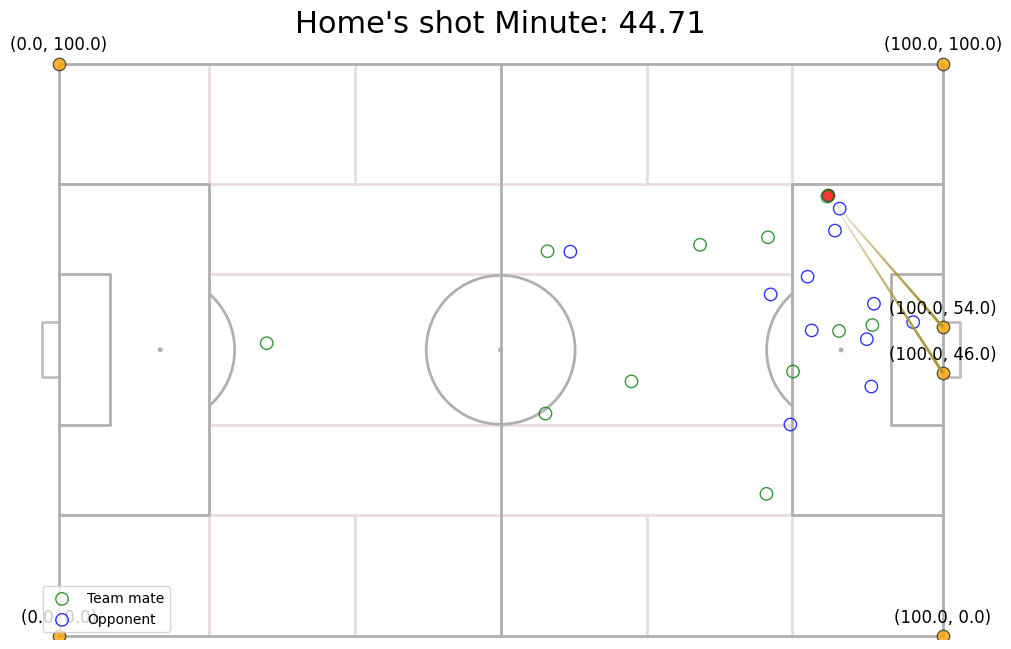

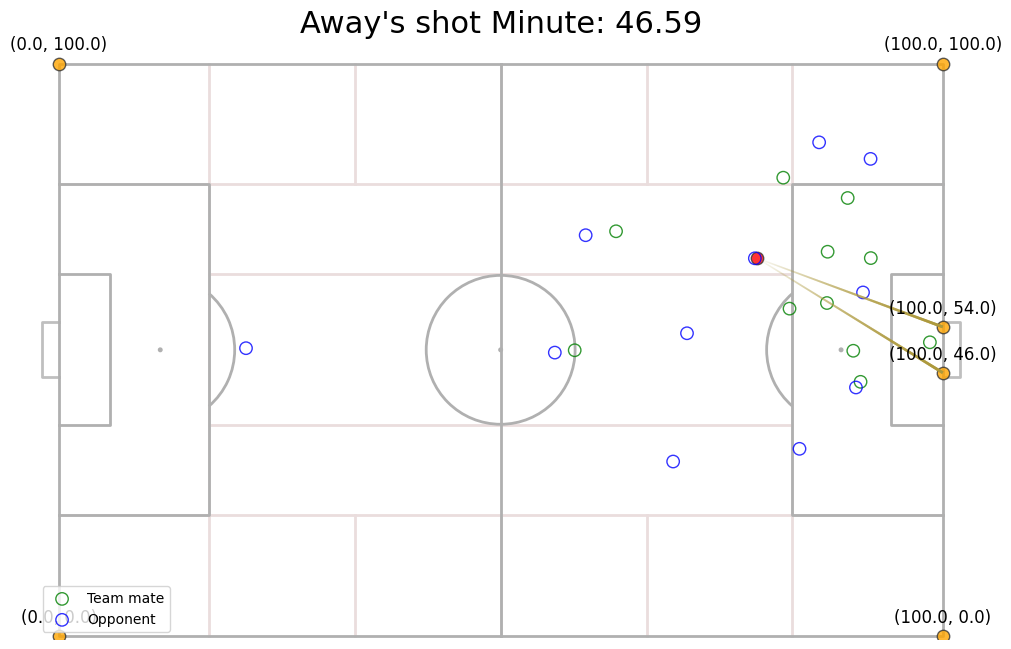

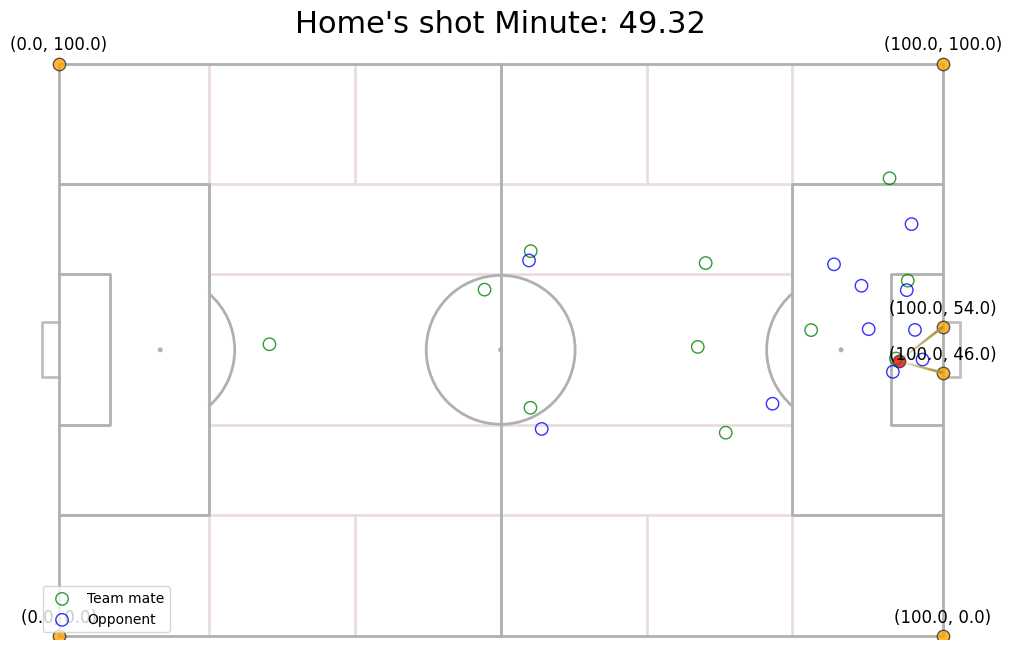

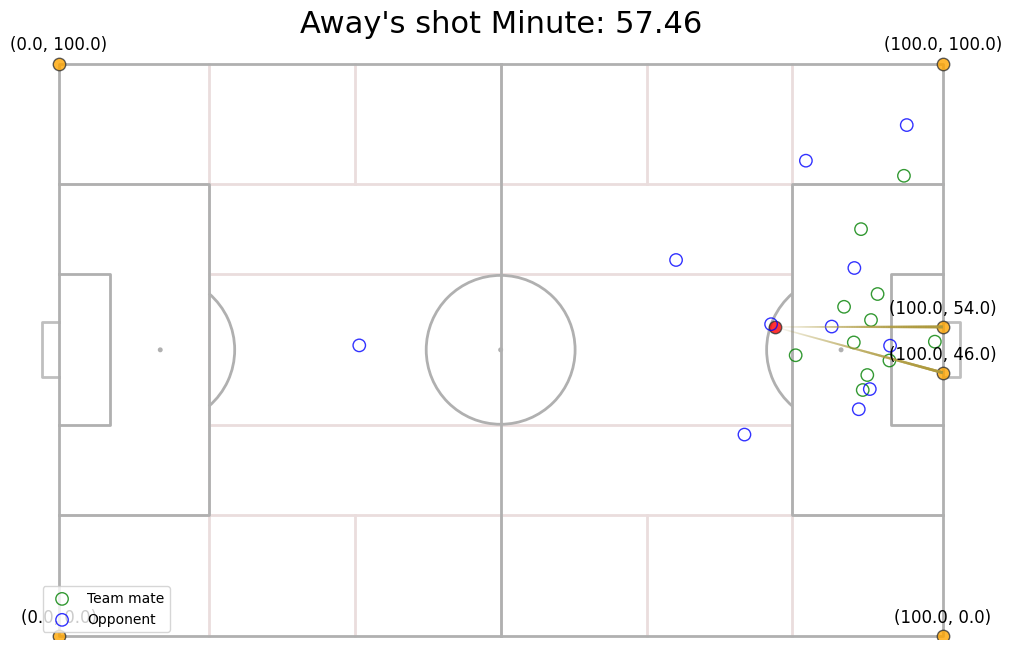

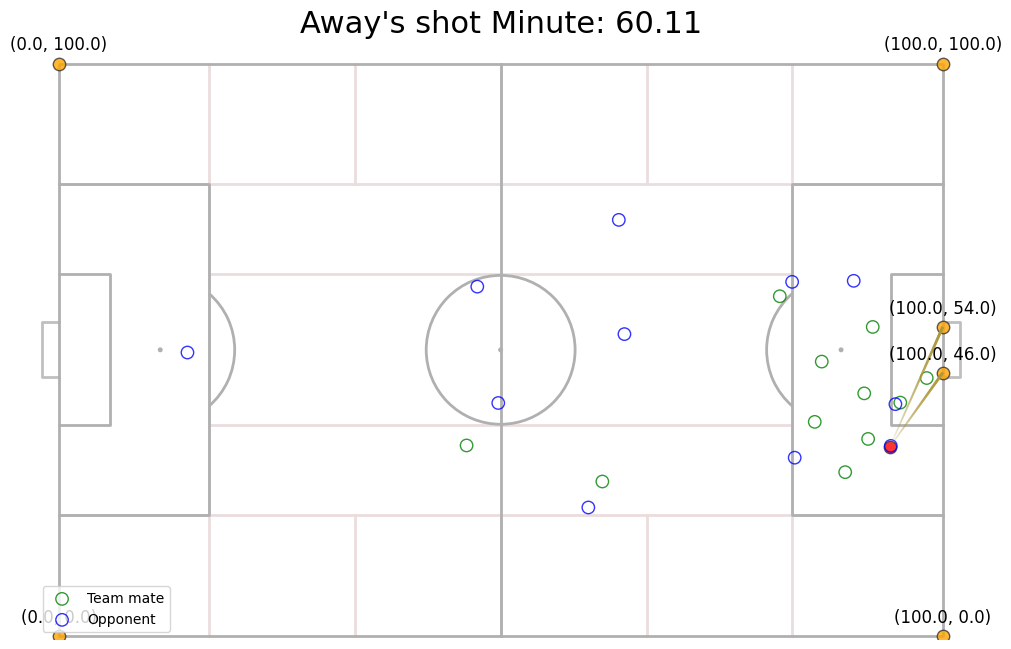

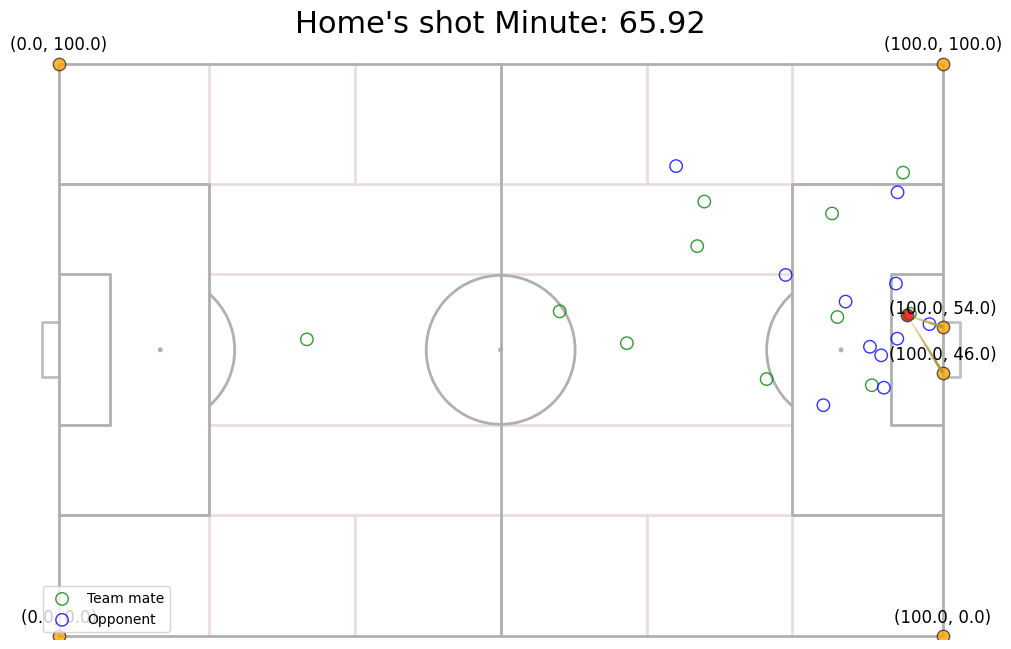

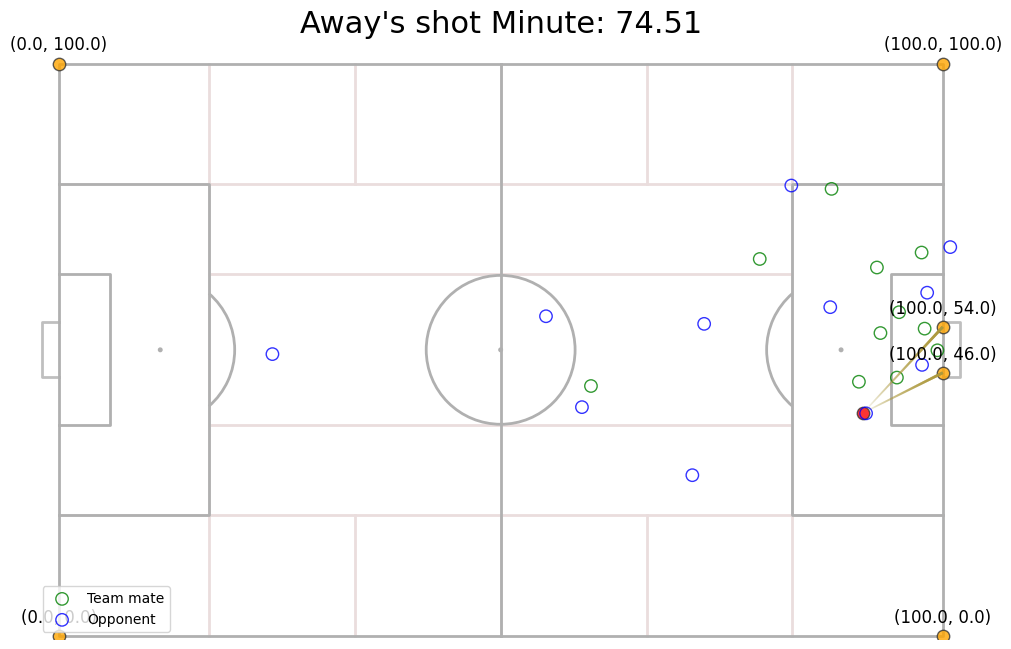

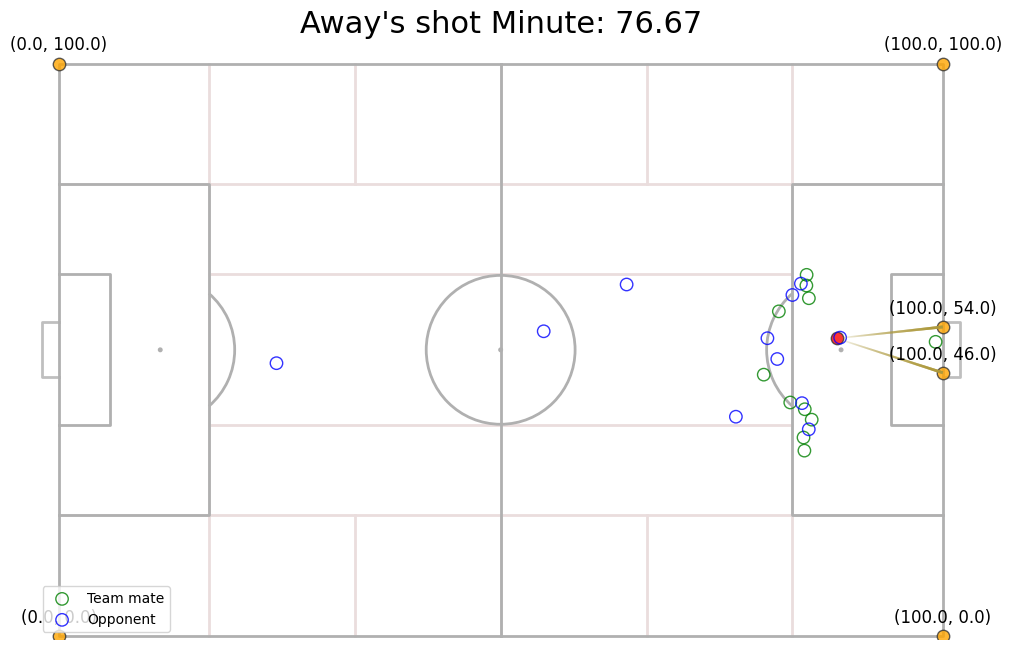

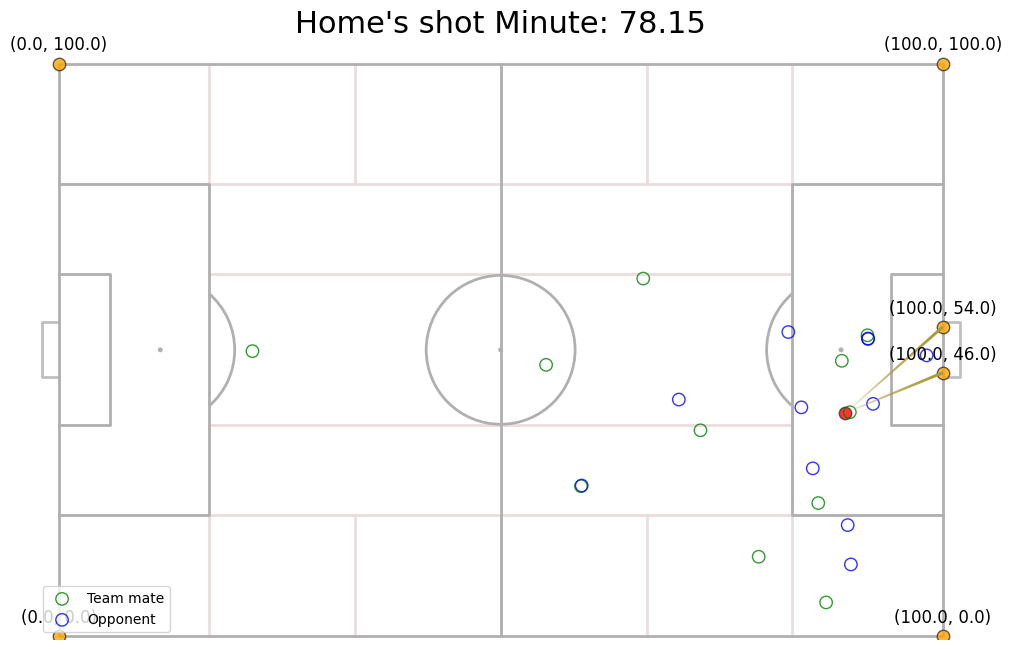

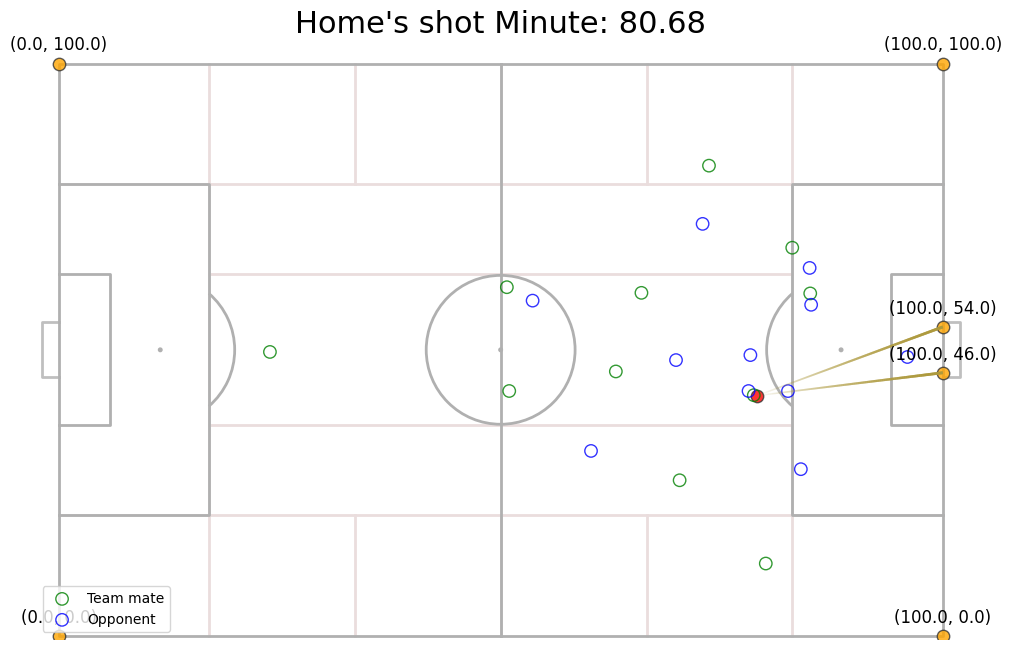

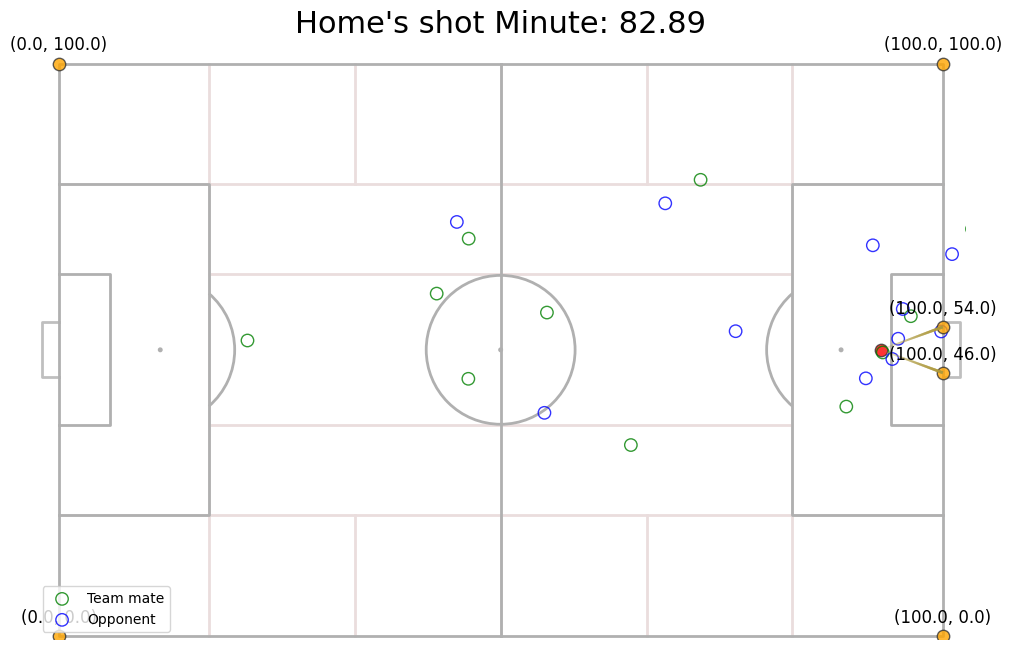

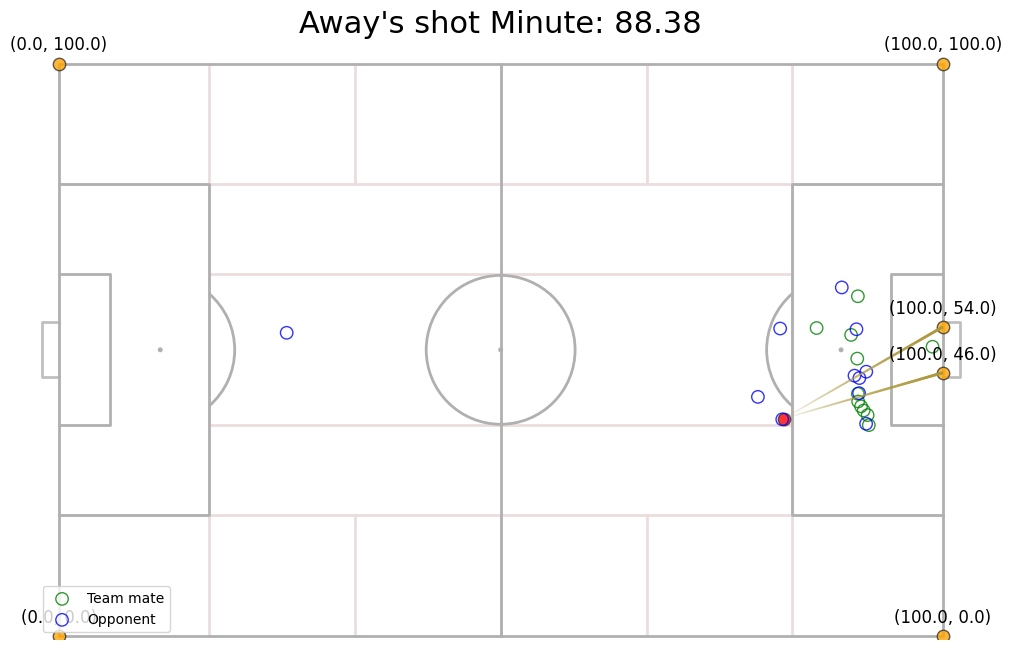

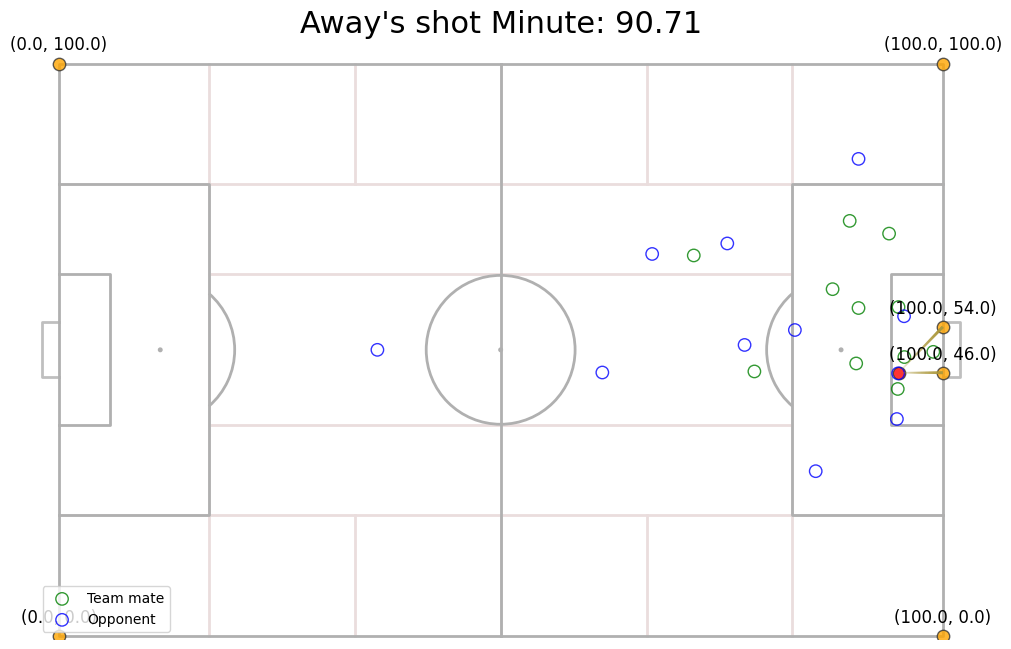

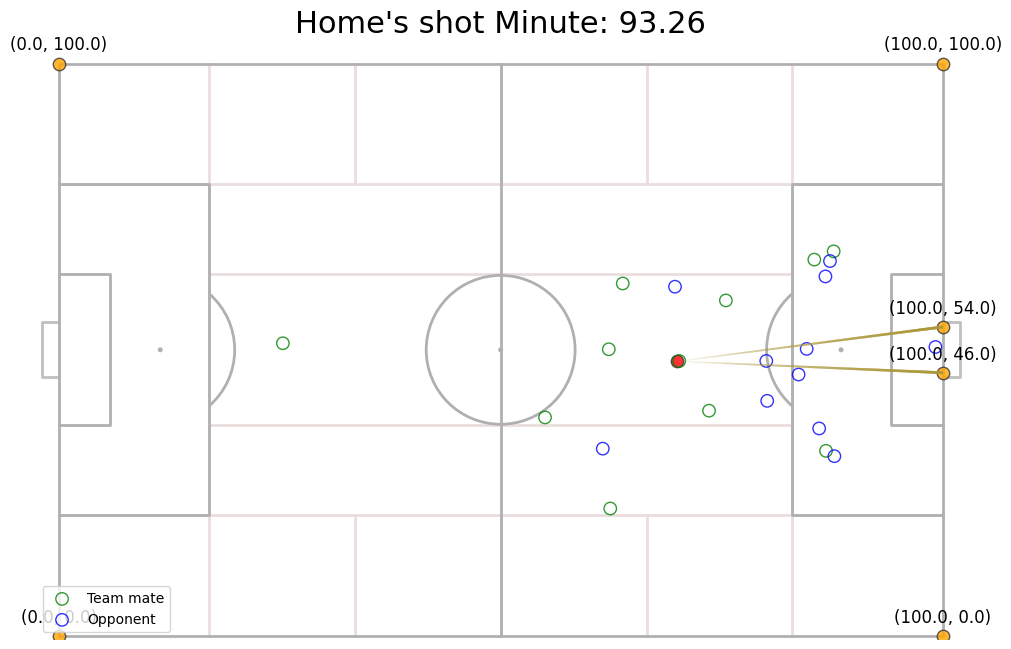

In [16]:
for i in range(0, len(df)):
    shot = df.take([i])
    plot_shot_detail(shot, "shot", "s")

In [17]:
df

,Team,Type,Subtype,Period,Start Frame,Time [s],End Frame,End Time [s],From,To,...,isGoal,Minute,Number_Intervening_Teammates,Number_Intervening_Opponents,Interference_on_Shooter,shot_a,shot_b,shot_c,shot_angle,zone
83,Home,SHOT,OFF TARGET-OUT,1,4419,176.76,4443,177.72,Player5,NaN,...,Other,2.946000,0,2,Low,26.42,33.62,29.97,6.71,Zone 14
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,...,Goal,8.134667,0,1,Medium,10.30,5.10,7.07,49.59,Zone 2
252,Home,SHOT,ON TARGET-SAVED,1,16484,659.36,16499,659.96,Player10,NaN,...,Other,10.989333,0,2,Low,17.03,23.71,20.25,12.58,Zone 9
297,Away,SHOT,BLOCKED,1,18515,740.60,18520,740.80,Player22,NaN,...,Other,12.343333,1,1,Medium,27.59,22.83,25.00,14.72,Zone 21
431,Home,SHOT,HEAD-OFF TARGET-OUT,1,27345,1093.80,27360,1094.40,Player3,NaN,...,Other,18.230000,0,1,Medium,15.81,10.30,12.73,26.27,Zone 7
472,Home,SHOT,ON TARGET-SAVED,1,29754,1190.16,29777,1191.08,Player4,NaN,...,Other,19.836000,0,2,Low,31.24,25.61,28.28,11.53,Zone 21
823,Away,SHOT,ON TARGET-GOAL,1,53049,2121.96,53075,2123.00,Player24,NaN,...,Goal,35.366000,1,0,Medium,11.31,8.00,8.94,45.02,Zone 6
852,Home,SHOT,HEAD-OFF TARGET-OUT,1,56079,2243.16,56131,2245.24,Player5,NaN,...,Other,37.386000,0,2,Low,11.18,16.40,13.45,25.87,Zone 8
962,Away,SHOT,OFF TARGET-HEAD-OUT,1,63362,2534.48,63372,2534.88,Player23,NaN,...,Other,42.241333,1,0,Medium,8.60,7.62,7.07,58.73,Zone 6
980,Away,SHOT,ON TARGET-SAVED,1,64772,2590.88,64799,2591.96,Player20,NaN,...,Other,43.181333,3,1,Medium,23.02,24.70,23.54,18.88,Zone 16


In [18]:
df.to_excel("Shot_data_metrica.xlsx", index = False)

In [19]:
goals = df[df['isGoal'] == 'Goal']
goals_openplay = goals[goals['PreviousType'] != 'SET PIECE']
goals

,Team,Type,Subtype,Period,Start Frame,Time [s],End Frame,End Time [s],From,To,...,isGoal,Minute,Number_Intervening_Teammates,Number_Intervening_Opponents,Interference_on_Shooter,shot_a,shot_b,shot_c,shot_angle,zone
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,...,Goal,8.134667,0,1,Medium,10.30,5.10,7.07,49.59,Zone 2
823,Away,SHOT,ON TARGET-GOAL,1,53049,2121.96,53075,2123.00,Player24,NaN,...,Goal,35.366000,1,0,Medium,11.31,8.00,8.94,45.02,Zone 6
1118,Home,SHOT,HEAD-ON TARGET-GOAL,2,73983,2959.32,73995,2959.80,Player9,NaN,...,Goal,49.322000,0,1,Medium,5.39,7.81,5.39,71.98,Zone 1
1671,Away,SHOT,ON TARGET-GOAL,2,115009,4600.36,115024,4600.96,Player20,NaN,...,Goal,76.672667,1,0,Medium,13.42,12.17,12.17,36.02,Zone 11
1723,Home,SHOT,ON TARGET-GOAL,2,121027,4841.08,121055,4842.20,Player12,NaN,...,Goal,80.684667,0,2,Medium,21.38,24.19,22.47,18.96,Zone 16


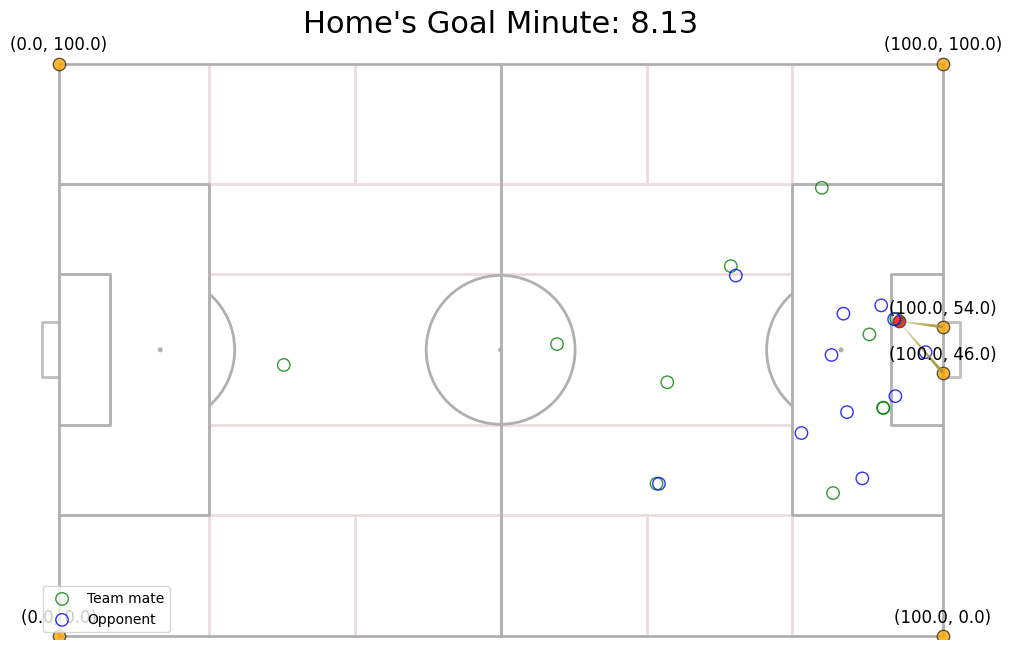

In [20]:
shot = goals_openplay.take([0])
plot_shot_detail(shot, "Goal", "Goal1")

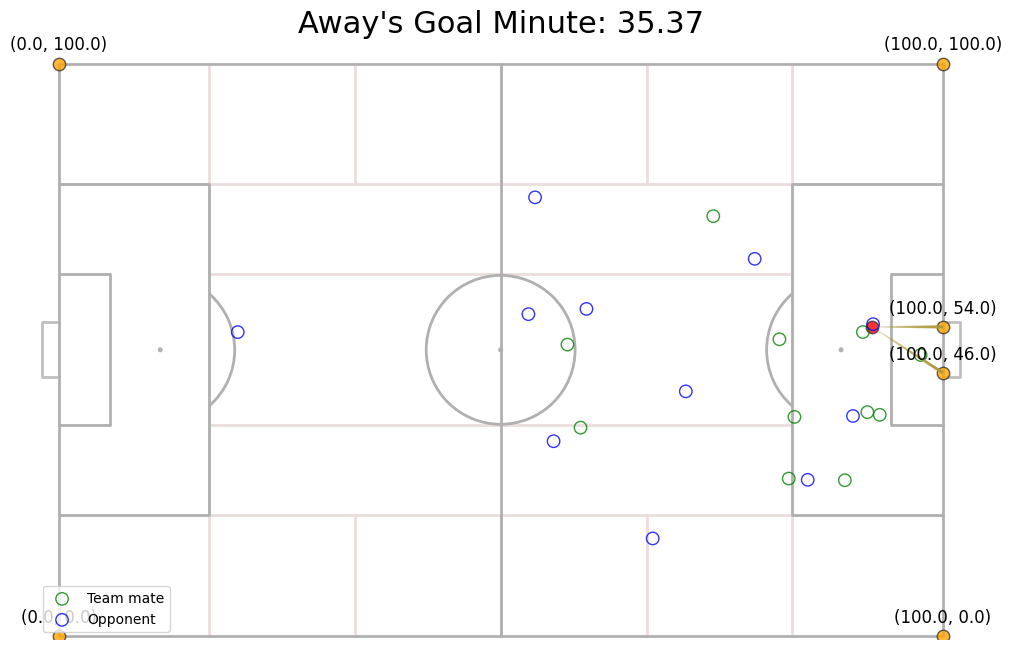

In [21]:
shot = goals_openplay.take([1])
plot_shot_detail(shot, "Goal", "Goal2")

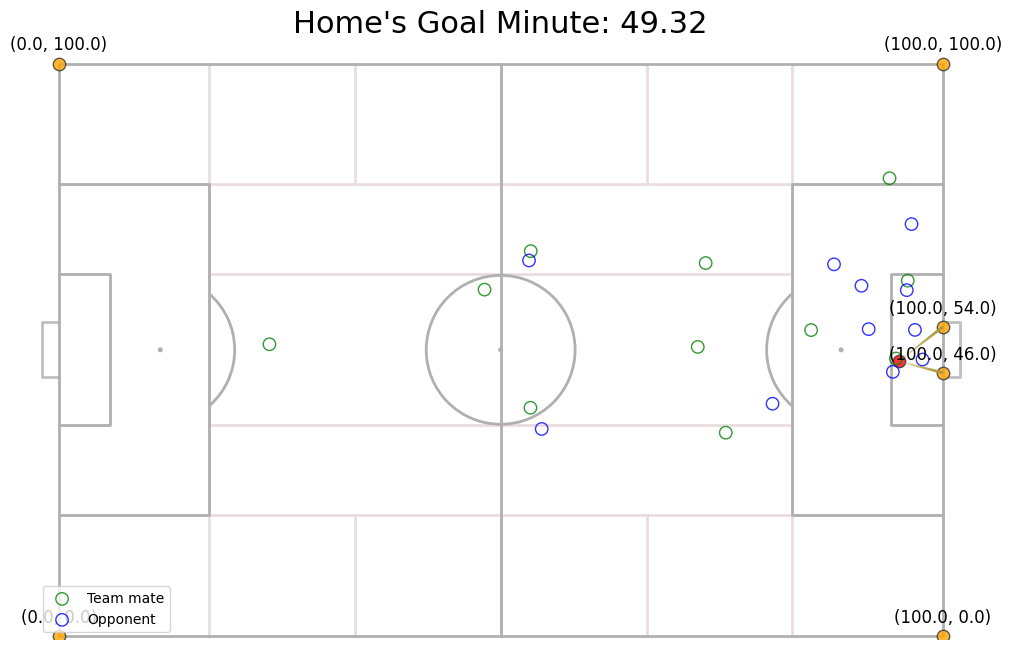

In [22]:
shot = goals_openplay.take([2])
plot_shot_detail(shot, "Goal", "Goal3")

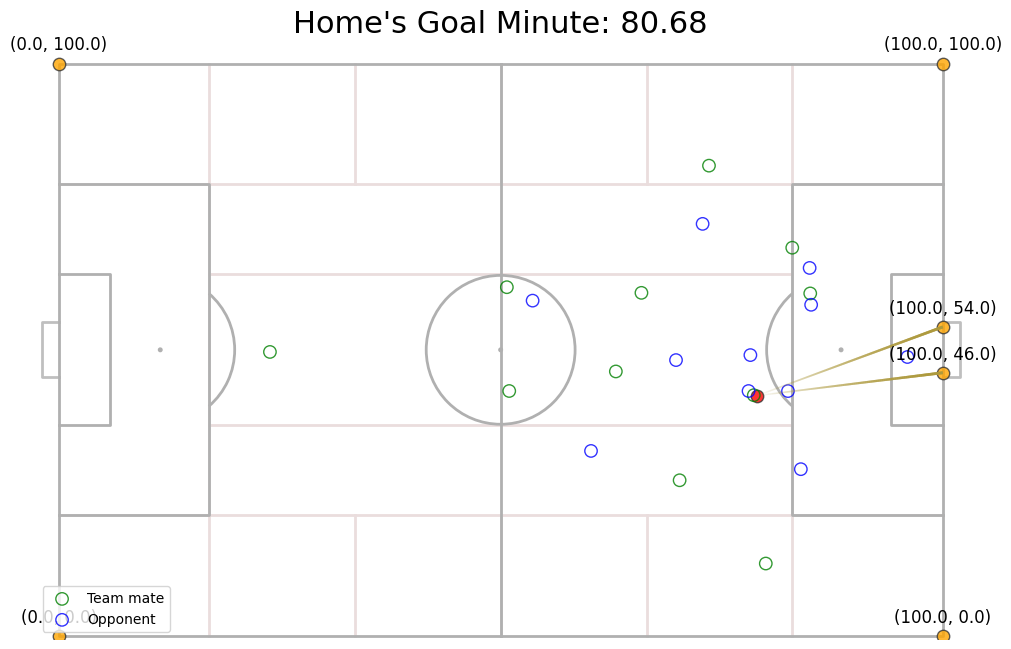

In [23]:
shot = goals_openplay.take([3])
plot_shot_detail(shot, "Goal", "Goal4")